# Google and Facebook 2015 and 2016

Import Necessary Libraries

In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import pmdarima as pm

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

Load the dataset

In [2]:
df = pd.read_csv('data.csv', parse_dates=['date'], index_col='date')
df.head()

,FB,GOOG
date,,
2015-01-02,78.45,524.81
2015-01-05,77.19,513.87
2015-01-06,76.15,501.96
2015-01-07,76.15,501.10
2015-01-08,78.18,502.68


## Numerical Simulation

### 1. Calculate the Daily Returns for FB and GOOG Stocks

**Daily Returns Calculation**:

The daily return is calculated as the percentage change between the current day’s closing price and the previous day’s closing price.

In [3]:
# Calculate daily returns
daily_returns = df.pct_change().dropna()
daily_returns.head()

,FB,GOOG
date,,
2015-01-05,-0.016061,-0.020846
2015-01-06,-0.013473,-0.023177
2015-01-07,0.000000,-0.001713
2015-01-08,0.026658,0.003153
2015-01-09,-0.005628,-0.012951


**Compute the Mean and Standard Deviation**:

In [4]:
# Compute mean of daily returns
mean_returns = daily_returns.mean()
print("Mean Daily Returns:")
print(mean_returns)

# Compute standard deviation of daily returns
std_returns = daily_returns.std()
print("\nStandard Deviation of Daily Returns:")
print(std_returns)

Mean Daily Returns:
FB      0.000905
GOOG    0.000890
dtype: float64

Standard Deviation of Daily Returns:
FB      0.017050
GOOG    0.015894
dtype: float64


### 2. Simulate the Future Price of FB and GOOG Stocks Over the Next 30 Days

We’ll use the mean daily return to simulate future prices using a simple stochastic model.

**Simulation Parameters**:

In [5]:
# Number of days to simulate
num_days = 30

# Last known prices
last_price_FB = df['FB'][-1]
last_price_GOOG = df['GOOG'][-1]

**Simulate Future Prices**:

In [6]:
# Arrays to store simulated prices
simulated_prices_FB = [last_price_FB]
simulated_prices_GOOG = [last_price_GOOG]

# Simulate future prices
for _ in range(num_days):
    next_price_FB = simulated_prices_FB[-1] * (1 + np.random.normal(mean_returns['FB'], std_returns['FB']))
    next_price_GOOG = simulated_prices_GOOG[-1] * (1 + np.random.normal(mean_returns['GOOG'], std_returns['GOOG']))
    simulated_prices_FB.append(next_price_FB)
    simulated_prices_GOOG.append(next_price_GOOG)

**Plot the Simulated Prices**:

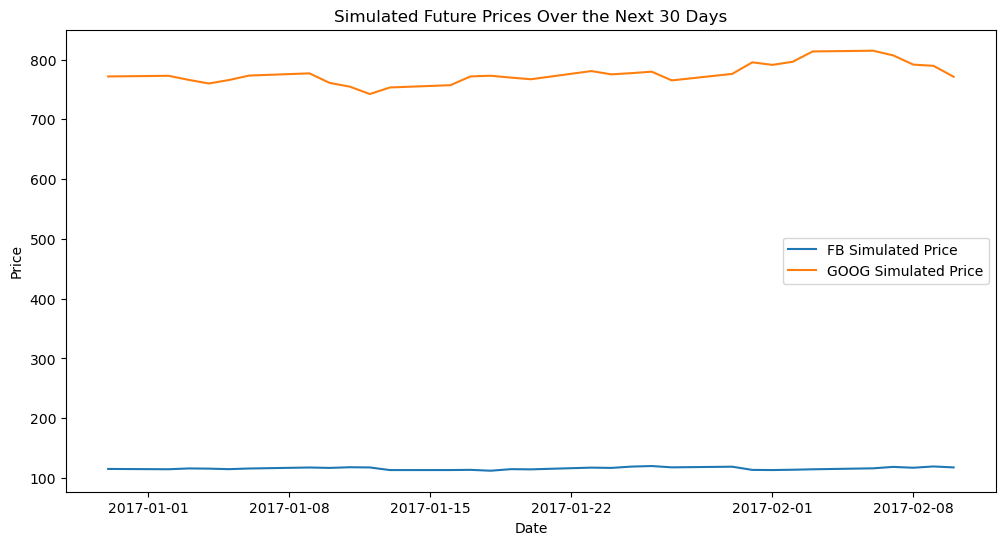

In [7]:
# Create date range for future dates
future_dates = pd.date_range(start=df.index[-1], periods=num_days+1, freq='B')

# Plot the simulated prices
plt.figure(figsize=(12,6))
plt.plot(future_dates, simulated_prices_FB, label='FB Simulated Price')
plt.plot(future_dates, simulated_prices_GOOG, label='GOOG Simulated Price')
plt.title('Simulated Future Prices Over the Next 30 Days')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

## Monte Carlo Simulation

### 3. Estimate the Expected Price of GOOG Stock After 60 Days

We’ll run 1,000 simulations to estimate the expected price.

**Simulation Parameters**:

In [8]:
# Monte Carlo simulation parameters
num_simulations = 1000
num_days = 60
start_price_GOOG = df['GOOG'][-1]

**Run the Monte Carlo Simulation**:

In [9]:
# Array to store the ending prices
ending_prices_GOOG = []

for _ in range(num_simulations):
    prices = [start_price_GOOG]
    for _ in range(num_days):
        next_price = prices[-1] * (1 + np.random.normal(mean_returns['GOOG'], std_returns['GOOG']))
        prices.append(next_price)
    ending_prices_GOOG.append(prices[-1])

**Calculate the average ending price**:

In [10]:
average_ending_price = np.mean(ending_prices_GOOG)
print(f"The expected price of GOOG stock after {num_days} days is ${average_ending_price:.2f}")

The expected price of GOOG stock after 60 days is $813.20


**Plot the Distribution of Ending Prices**:

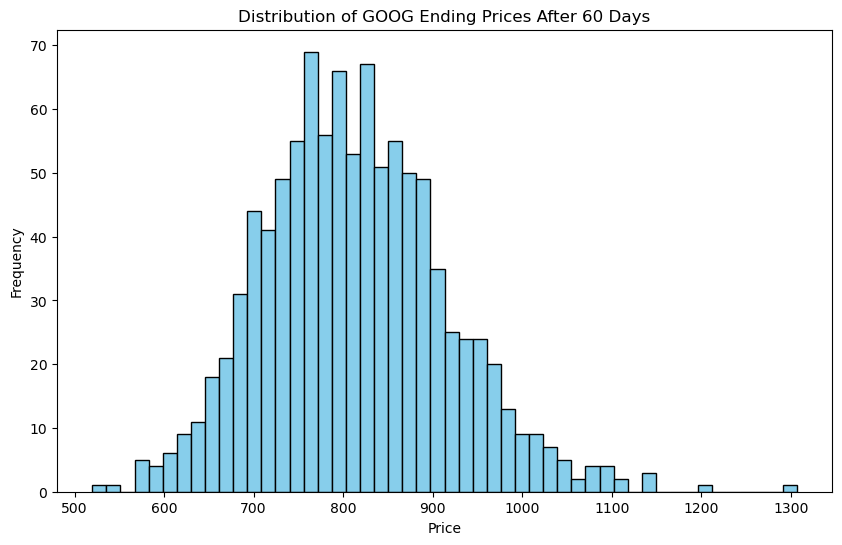

In [11]:
# Plot histogram of ending prices
plt.figure(figsize=(10,6))
plt.hist(ending_prices_GOOG, bins=50, color='skyblue', edgecolor='black')
plt.title('Distribution of GOOG Ending Prices After 60 Days')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()

### 4. Estimate the Probability That FB Stock Price Will Exceed $150 After 30 Days

**Simulation Parameters**:

In [12]:
# Monte Carlo simulation parameters
num_simulations = 1000
num_days = 30
start_price_FB = df['FB'][-1]
threshold_price = 150

**Run Simulations**:

In [13]:
# Counter for simulations where price exceeds $150
count_exceed = 0

for _ in range(num_simulations):
    prices = [start_price_FB]
    for _ in range(num_days):
        next_price = prices[-1] * (1 + np.random.normal(mean_returns['FB'], std_returns['FB']))
        prices.append(next_price)
    if prices[-1] > threshold_price:
        count_exceed += 1

**Calculate the Probability**:

In [14]:
probability_exceed = count_exceed / num_simulations
print(f"The probability that FB stock price will exceed ${threshold_price} after {num_days} days is {probability_exceed:.2%}")

The probability that FB stock price will exceed $150 after 30 days is 0.50%


## Time Series Forecasting

### 5. Forecast FB Stock Prices for the Next 10 Days Using an ARIMA Model

**Check for Stationarity**:

In [15]:
# Perform Augmented Dickey-Fuller test
result = adfuller(df['FB'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -1.414790
p-value: 0.575166


If the p-value is greater than 0.05, the series is non-stationary, and we need to difference it.

**Fit ARIMA Model**:

In [16]:
# Fit ARIMA model using auto_arima to find optimal parameters
model_FB = pm.auto_arima(df['FB'], seasonal=False, trace=True, error_action='ignore', suppress_warnings=True)
print(model_FB.summary())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1964.669, Time=0.29 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1968.627, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1969.031, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1968.995, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1967.542, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1964.119, Time=0.09 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=1970.994, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1970.995, Time=0.06 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=1960.835, Time=0.09 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=1961.032, Time=0.03 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=1962.266, Time=0.11 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=1959.011, Time=0.14 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=1961.239, Time=0.04 sec
 ARIMA(2,1,4)(0,0,0)[0] intercept   : AIC=1960.826, Time=0.17 sec
 ARIMA(1,1,5)(0,0,0)[0] intercept

**Forecast the Next 10 Days**:

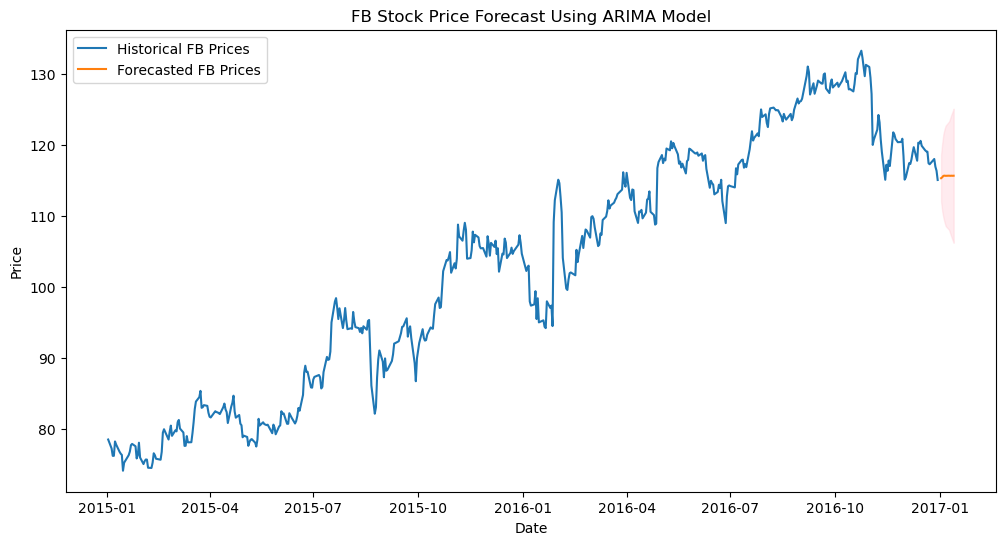

In [17]:
# Forecast next 10 days
n_days = 10
forecast_FB, conf_int_FB = model_FB.predict(n_periods=n_days, return_conf_int=True)

# Create date index for future dates
forecast_dates_FB = pd.date_range(start=df.index[-1], periods=n_days+1, freq='B')[1:]

# Plot the forecast
plt.figure(figsize=(12,6))
plt.plot(df['FB'], label='Historical FB Prices')
plt.plot(forecast_dates_FB, forecast_FB, label='Forecasted FB Prices')
plt.fill_between(forecast_dates_FB, conf_int_FB[:,0], conf_int_FB[:,1], color='pink', alpha=0.3)
plt.title('FB Stock Price Forecast Using ARIMA Model')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

### 6. Forecast GOOG Stock Prices Over the Next 10 Days Using Exponential Smoothing

**Fit Exponential Smoothing Model**:

In [18]:
# Fit Exponential Smoothing model
model_GOOG = ExponentialSmoothing(df['GOOG'], trend='add', seasonal=None).fit()

**Forecast the Next 10 Days**:

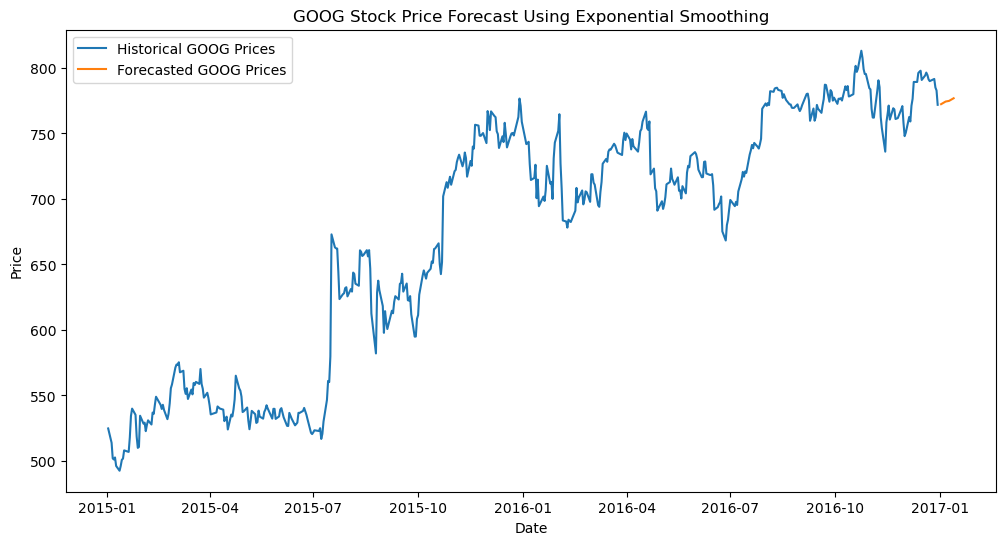

In [19]:
# Forecast next 10 days
forecast_GOOG = model_GOOG.forecast(steps=10)

# Create date index for future dates
forecast_dates_GOOG = pd.date_range(start=df.index[-1], periods=11, freq='B')[1:]

# Plot the forecast
plt.figure(figsize=(12,6))
plt.plot(df['GOOG'], label='Historical GOOG Prices')
plt.plot(forecast_dates_GOOG, forecast_GOOG, label='Forecasted GOOG Prices')
plt.title('GOOG Stock Price Forecast Using Exponential Smoothing')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()